# Manufacturing Defects

In [ ]:
# Challenges
# -------------------
# Imbalanced Data:
# The dataset initially had an unequal distribution of severity levels. SMOTE helped balance the training set, but the test set's real-world imbalance may have affected performance.

# Limited Feature Complexity:
# The available features may not fully capture all the factors influencing severity, such as environmental conditions, production process details, or operator expertise.

# Model Performance:
# The models' accuracy and F1 scores (~30%) suggest that the problem is challenging and may require additional features or more advanced algorithms to improve predictions.

# Potential Overfitting in Initial Efforts:
# Previous results with perfect evaluation metrics (100% accuracy) indicated overfitting or data leakage. These issues were addressed by using SMOTE, stratified splits, and careful cross-validation.

# Conclusion
# -------------------
# While the project successfully applied machine learning to analyze manufacturing defects and predict severity, the moderate performance metrics highlight areas for improvement. The following steps could enhance the results:

# Collecting more features relevant to defect severity (e.g., material properties, production line details).
# Leveraging more advanced algorithms, such as neural networks, or domain-specific models.
# Exploring ensemble methods or stacked models for better predictions.
# Enhancing interpretability with domain-specific rules to supplement machine learning models.

# The project demonstrates the potential of machine learning in quality control but also emphasizes the need for more detailed data and advanced methods to achieve high accuracy in real-world applications.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import zipfile
import joblib
import shap
from imblearn.over_sampling import SMOTE

In [2]:
# Step 1: Extract Data from Zip File
zip_file_path = 'Manufacturing Defects.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()
    extracted_files = zip_ref.namelist()
    print("Files extracted from Manufacturing Defects.zip:", extracted_files)

# Load the CSV file
csv_file_name = extracted_files[0]  # Assuming single CSV file
df = pd.read_csv(csv_file_name)

# Inspect the first few rows
print("\nInitial Dataset Overview:")
print(df.head())

# Dataset information
print("\nDataset Info:")
print(df.info())

Files extracted from Manufacturing Defects.zip: ['defects_data.csv']

Initial Dataset Overview:
   defect_id  product_id defect_type defect_date defect_location  severity  \
0          1          15  Structural    6/6/2024       Component     Minor   
1          2           6  Functional   4/26/2024       Component     Minor   
2          3          84  Structural   2/15/2024        Internal     Minor   
3          4          10  Functional   3/28/2024        Internal  Critical   
4          5          14    Cosmetic   4/26/2024       Component     Minor   

   inspection_method  repair_cost  
0  Visual Inspection       245.47  
1  Visual Inspection        26.87  
2  Automated Testing       835.81  
3  Automated Testing       444.47  
4     Manual Testing       823.64  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0 

In [3]:
# Data Cleaning and Feature Engineering

# Convert 'defect_date' to datetime
df['defect_date'] = pd.to_datetime(df['defect_date'], errors='coerce')

# Extract features from defect_date
df['defect_year'] = df['defect_date'].dt.year
df['defect_month'] = df['defect_date'].dt.month
df['defect_day'] = df['defect_date'].dt.day

# Drop defect_date (redundant after extraction)
df.drop(columns=['defect_date'], inplace=True)

# Inspect missing values
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

# Handle categorical columns using Label Encoding
categorical_columns = ['defect_type', 'defect_location', 'inspection_method', 'severity']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Inspect Label Encodings
for col, le in label_encoders.items():
    print(f"\nLabel Encoding for {col}:")
    print(dict(zip(le.classes_, le.transform(le.classes_))))

# Inspect cleaned dataset
print("\nCleaned Dataset Head:")
print(df.head())


Missing Values Before Cleaning:
defect_id            0
product_id           0
defect_type          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
defect_year          0
defect_month         0
defect_day           0
dtype: int64

Label Encoding for defect_type:
{'Cosmetic': 0, 'Functional': 1, 'Structural': 2}

Label Encoding for defect_location:
{'Component': 0, 'Internal': 1, 'Surface': 2}

Label Encoding for inspection_method:
{'Automated Testing': 0, 'Manual Testing': 1, 'Visual Inspection': 2}

Label Encoding for severity:
{'Critical': 0, 'Minor': 1, 'Moderate': 2}

Cleaned Dataset Head:
   defect_id  product_id  defect_type  defect_location  severity  \
0          1          15            2                0         1   
1          2           6            1                0         1   
2          3          84            2                1         1   
3          4          10            1                1         0   
4          5 

C:\Users\milto\AppData\Local\Temp\ipykernel_20996\2117747698.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='severity', data=df, palette='viridis')


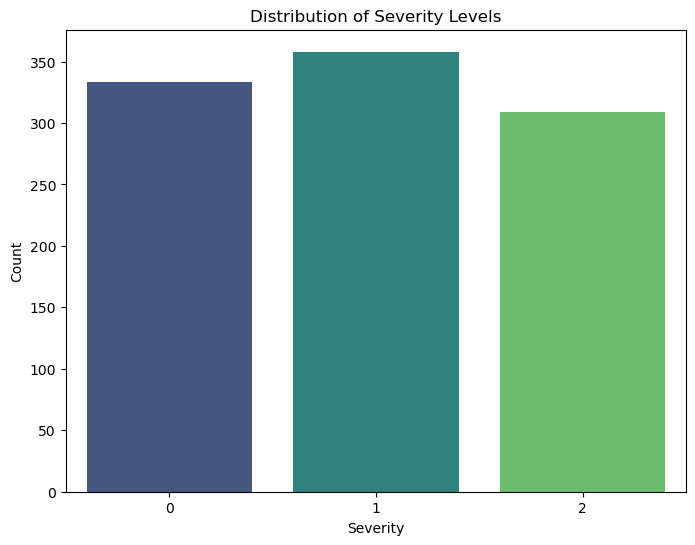

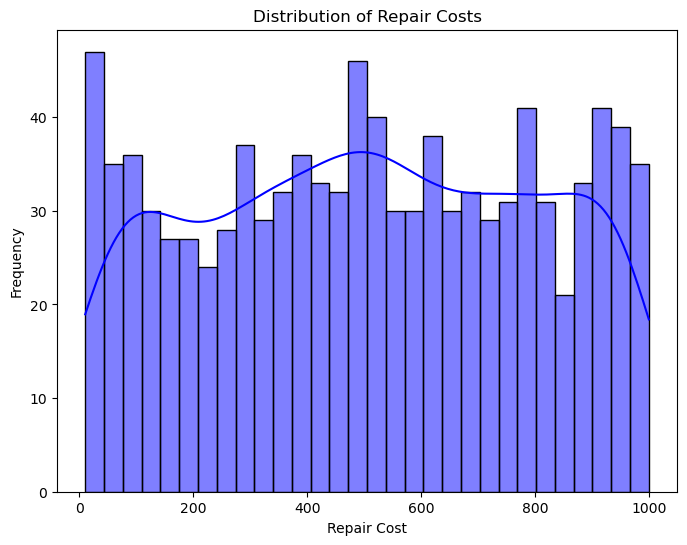

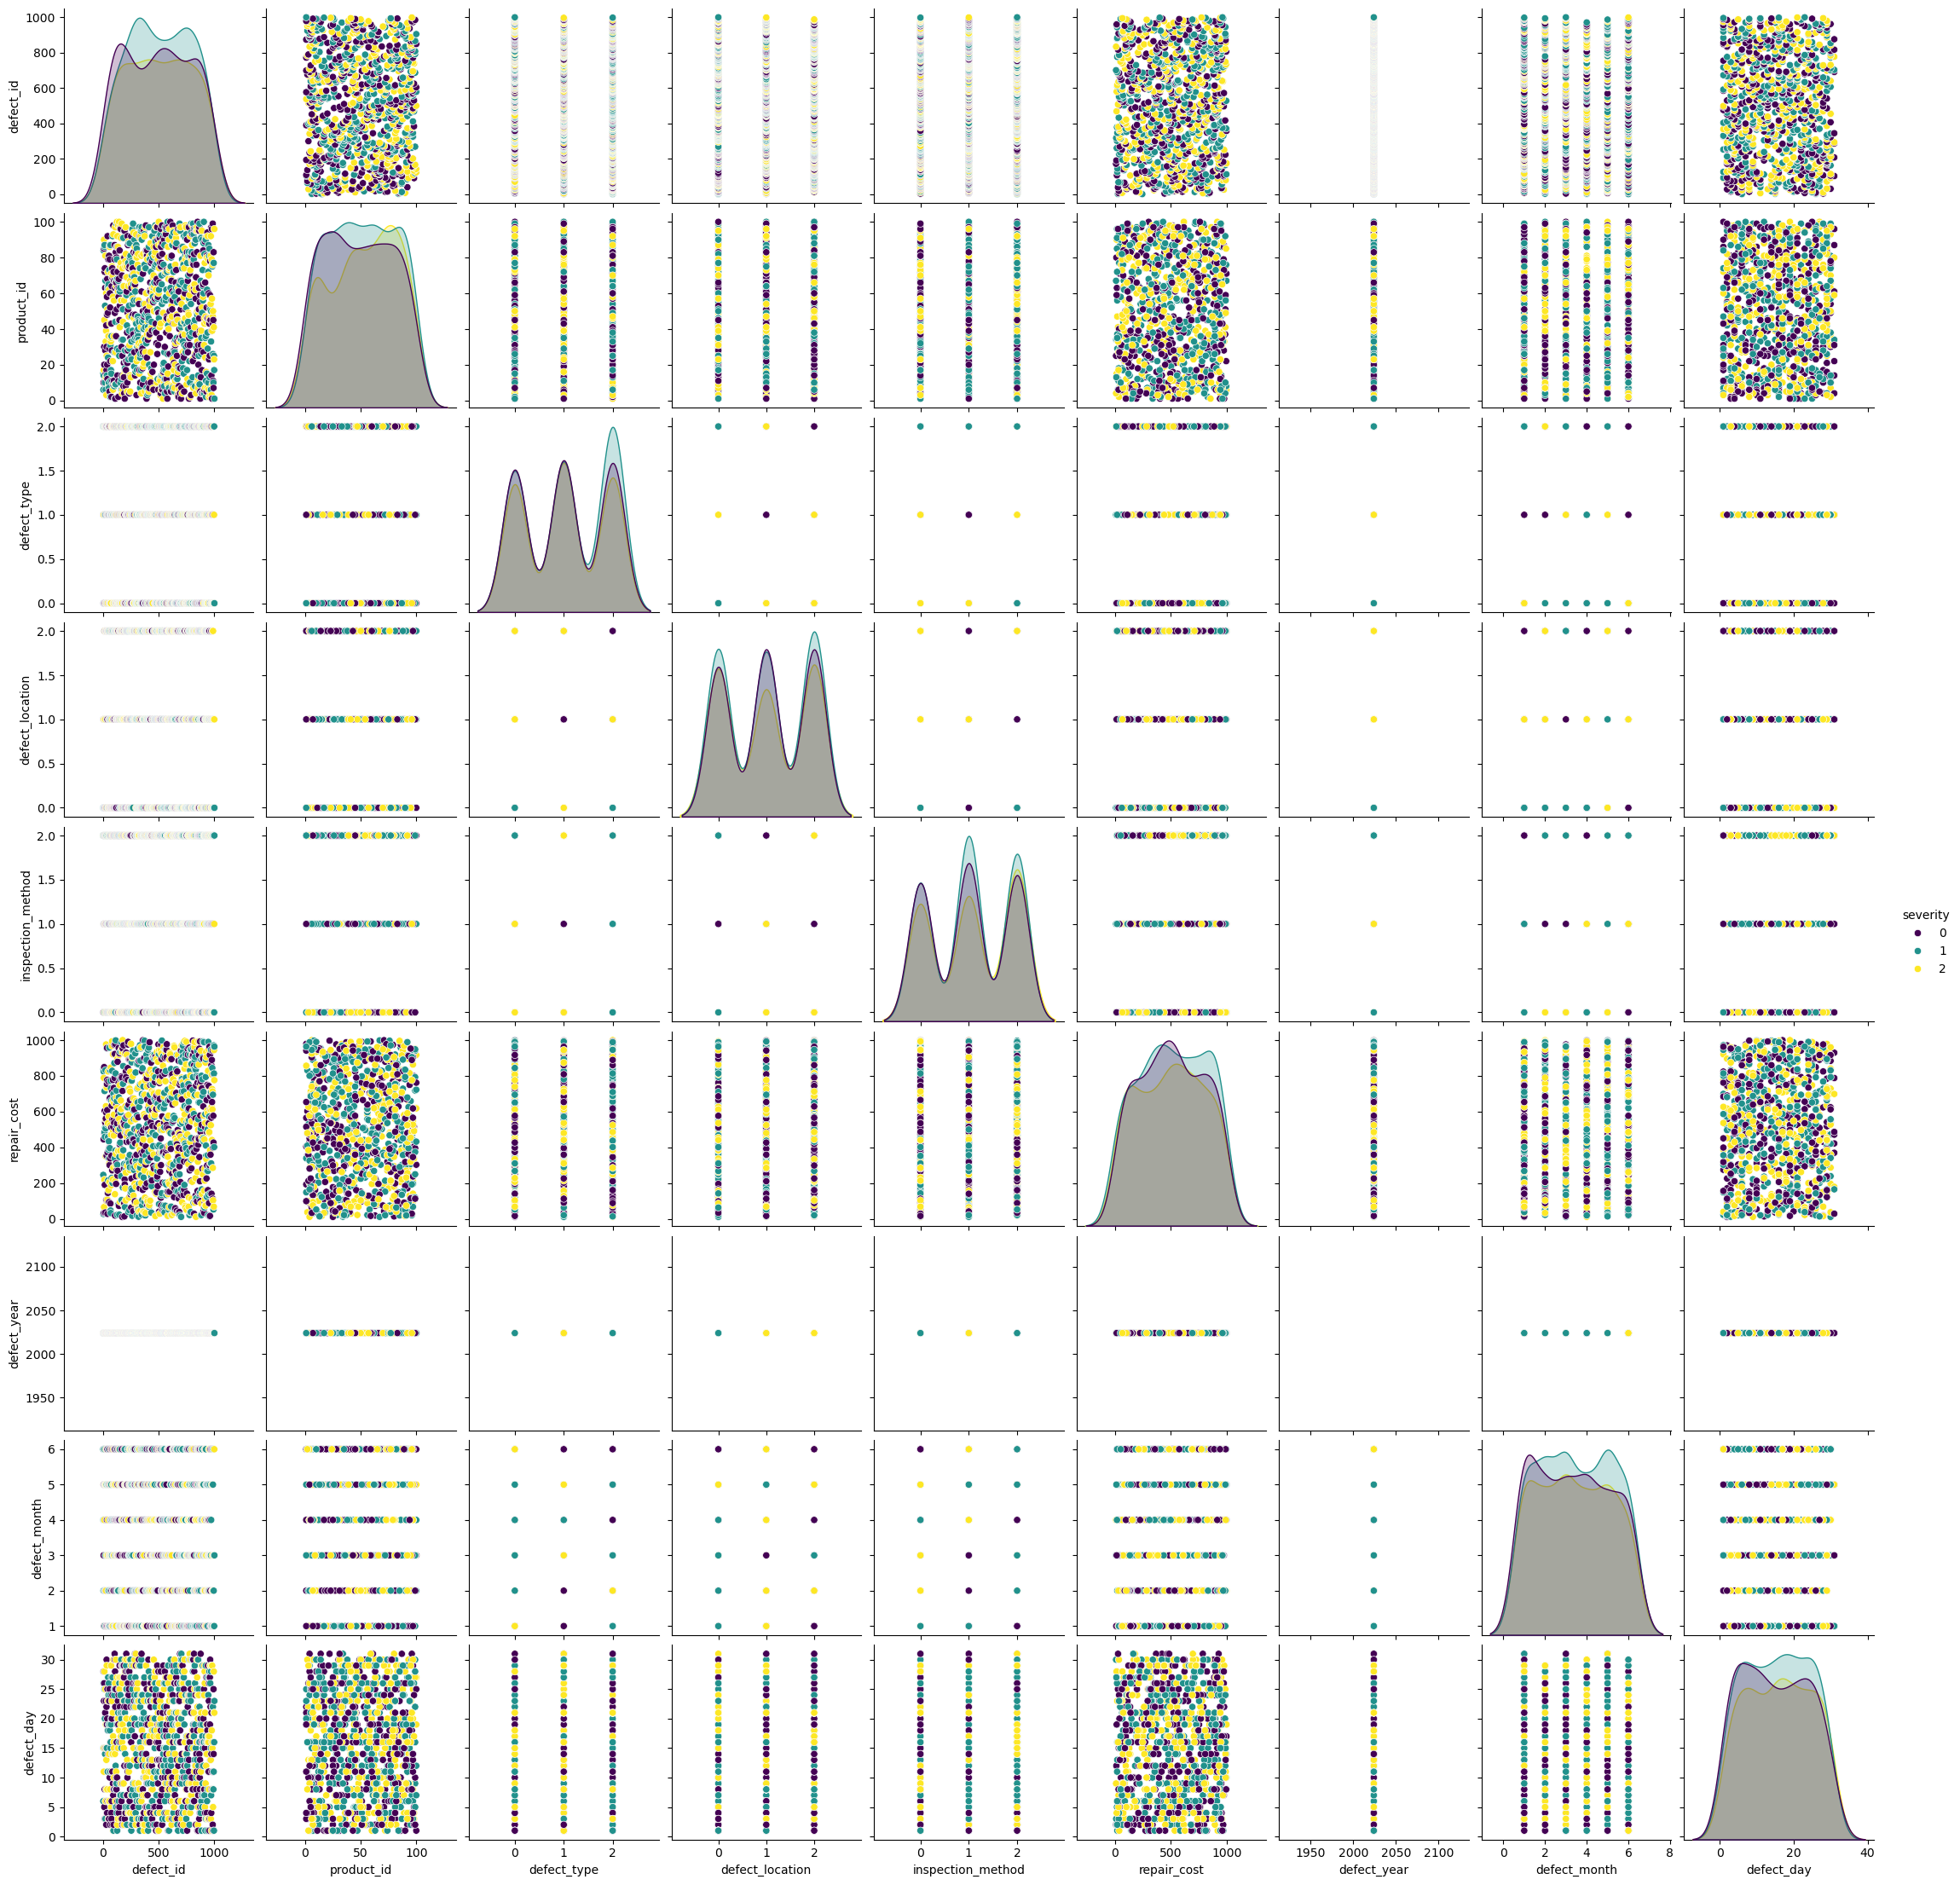

In [4]:
# Exploratory Data Analysis (EDA)

# Plot severity distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='severity', data=df, palette='viridis')
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

# Plot repair cost distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['repair_cost'], bins=30, kde=True, color='blue')
plt.title('Distribution of Repair Costs')
plt.xlabel('Repair Cost')
plt.ylabel('Frequency')
plt.show()

# Pairplot to explore relationships
sns.pairplot(df, hue='severity', palette='viridis')
plt.show()

In [6]:
# Data Splitting and Scaling

# Separate features and target
X = df.drop(columns=['severity'])
y = df['severity']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inspect scaled data
print("\nScaled Training Data - Mean:", X_train_scaled.mean(axis=0))
print("\nScaled Training Data - Standard Deviation:", X_train_scaled.std(axis=0))


Scaled Training Data - Mean: [ 3.55271368e-17  4.88498131e-17  6.43929354e-17 -4.66293670e-17
 -1.28785871e-16 -3.52495810e-16  0.00000000e+00  6.21724894e-17
  5.55111512e-17]

Scaled Training Data - Standard Deviation: [1. 1. 1. 1. 1. 1. 0. 1. 1.]


In [7]:
# Addressing Class Imbalance with SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Inspect the class distribution after SMOTE
print("\nClass Distribution After SMOTE:")
print(y_train_resampled.value_counts(normalize=True))


Class Distribution After SMOTE:
severity
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64


C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters from Grid Search:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.33      0.34        66
           1       0.34      0.32      0.33        72
           2       0.25      0.27      0.26        62

    accuracy                           0.31       200
   macro avg       0.31      0.31      0.31       200
weighted avg       0.31      0.31      0.31       200



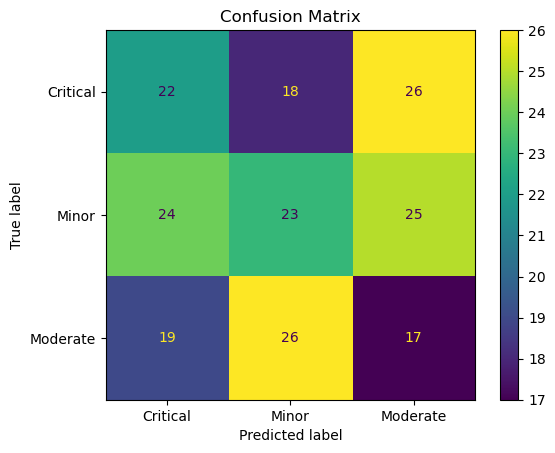

In [8]:
# Hyperparameter Tuning with XGBoost

# Initialize XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Output best parameters and model
print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoders['severity'].classes_)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()


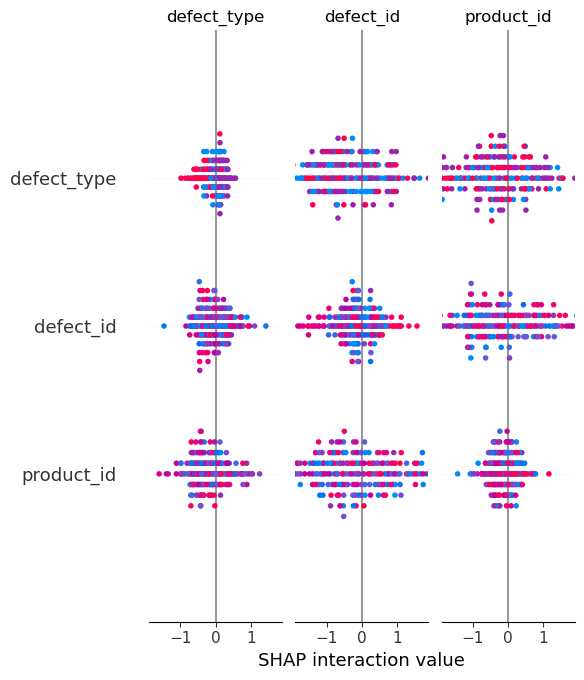

In [9]:
# Model Evaluation

# Explain predictions using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# Visualize feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)


In [11]:
# Save the Model and Processed Data

joblib.dump(best_model, 'manufacturing_defect_model.pkl')

# Save the processed dataset
df.to_csv('processed_defects_data.csv', index=False)

print("\nModel and processed data saved successfully!")



Model and processed data saved successfully!
